# `009` Embeddings

Requirements: 007 Batch normalization

Since neural networks are just mathematical functions that process numbers, we need to convert input data into numbers. Until now, all of our input data were either numeric parameters passed into a function, or images whose brightness values were used as numbers. But we may also want to process categorical data, such as texts.

One may thing of just mapping each letter to a number, but this would create false relationships between characters. For instance, `A` being `0`, `B` being `1`, and `N` being `13` would imply that `A` is closer to `B` than to `N`, which is not true.

One possible solution to this problem are one-hot encodings, where each character is represented by a vector of zeros, with a `1` in the position corresponding to the character. For instance, `A` would be `[1, 0, 0, ..., 0]`, `B` would be `[0, 1, 0, ..., 0]`, and `N` would be `[0, 0, 0, ..., 1]`. This way, the distance between any two characters is the same. This was the approach used until 2003, when Bengio et al. proposed **embeddings**. The idea behind embeddings is that each category has a vector of real numbers associated with it. These vectors are learned during training, and are updated just like any other parameter in the network. The network can then learn relationships between categories, such as that `A` is closer to `B` than to `N`.

Let's build a network that uses embeddings. But first, let's load a dataset of Spanish novels that we will be using.

In [1]:
from re import sub
import torch
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokens = ' !(),-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz¡¿ÁÉÍÑÓÚÜáéíñóúü'
t2i = {c: i for i, c in enumerate(tokens)}
i2t = {i: c for i, c in enumerate(tokens)}

with open('datasets/spanish-novels.txt', encoding='utf-8') as fp:
	data = fp.read()

data = sub(r'\s*\n\s*', ' ', data)
data = [t2i[c] for c in data if c in tokens]
data = torch.tensor(data, dtype=torch.long).to(device)
print(f'dataset size: {data.shape[0]} (that\'s like {100 * data.shape[0] / 20000000000000:.6f}% of GPT-4\'s training data)')

dataset size: 19263904 (that's like 0.000096% of GPT-4's training data)


Now, since we want to train a network to predict the next character in a text, our batches will be the previous characters, and the target will be the next character. The previous characters are often called the *context*.

In [2]:
def get_batch(size=32, context_size=16):
	starts = torch.randint(0, len(data) - context_size, (size,))
	x = torch.stack([data[s:s+context_size] for s in starts])
	y = torch.stack([data[s+context_size] for s in starts])
	return x, y

x, y = get_batch()
print(x.shape, y.shape)

torch.Size([32, 16]) torch.Size([32])


Now let's create the embedding layer. Even though this layer already exists in PyTorch, we will implement it from scratch to understand how it works.

In [3]:
class Embedding(torch.nn.Module):
	def __init__(self, vocab_size, embedding_size):
		super().__init__()
		# create a matrix where the first dimension is the token index, so that embedding[token_index] returns the embedding for that token
		self.weights = torch.randn(vocab_size, embedding_size, requires_grad=True, device=device)

	def forward(self, x):
		return self.weights[x]

Pretty simple, right? The embedding layer is just a matrix that maps each category to a vector of real numbers. The forward method just returns the rows of the matrix corresponding to the input indices. The key point is that since all the parameters are learned, the network will find a nice representation for the categories for the problem at hand.

Now let's create a simple network that starts by mapping the characters into embeddings. Modern networks have embedding sizes of 128-512 elements, but we will use 16 for simplicity.

In [4]:
def get_model(context_size=16, embedding_size=16, hidden_size=128, num_layers=8):
	res = [
		Embedding(len(tokens), embedding_size),
		torch.nn.Flatten(),
		torch.nn.Linear(context_size * embedding_size, hidden_size, bias=False),
		torch.nn.BatchNorm1d(hidden_size),
		torch.nn.ReLU()
	]
	for _ in range(num_layers):
		res.extend([
			torch.nn.Linear(hidden_size, hidden_size, bias=False),
			torch.nn.BatchNorm1d(hidden_size),
			torch.nn.ReLU()
		])
	res.extend([
		torch.nn.Linear(hidden_size, len(tokens))
	])
	return torch.nn.Sequential(*res).to(device)

model = get_model()
num_params = sum(p.numel() for p in model.parameters())
print(f'Model has {num_params} parameters (that\'s like {100 * num_params / 17000000000000:.8f}% of GPT-4\'s parameters)')

Model has 177625 parameters (that's like 0.00000104% of GPT-4's parameters)


Now, let's train our model. We will use the same training loop as before with a couple of changes:
* The optimizer used is Adam instead of gradient descent. We will talk more about Adam in the future, but for now, just know that it is a more advanced optimizer that usually converges faster.
* The loss function is now the cross-entropy loss. This loss function is used when the output is a probability distribution, which is the case here. The cross-entropy loss is defined as $-\sum_i y_i \log(p_i)$, where $y_i$ is the target probability and $p_i$ is the predicted probability. In our case, $y_i$ is a one-hot encoding of the target character, and $p_i$ is the output of the network. A way to think about cross-entropy is that it is a measure of how confident the network is about the correct answer. If the network is very confident and correct, the loss is low. If the network is very confident and wrong, the loss is high. If the network is not confident, the loss is high. This is a good loss function for classification problems.

In [5]:
def train(model, epochs=10000, batch_size=32, context_size=16, lr=1e-3):
	model.train()
	optimizer = torch.optim.Adam(model.parameters(), lr=lr)
	losses = []
	for epoch in range(epochs):
		x, y = get_batch(size=batch_size, context_size=context_size)
		optimizer.zero_grad()
		loss = torch.nn.functional.cross_entropy(model(x), y)
		loss.backward()
		optimizer.step()
		losses.append(loss.item())
		if epoch % 1000 == 0:
			print(f'epoch {epoch}, loss: {loss.item()}')
	return losses

To make the training more effective we are going to use a **schedule**, which is a way to change the learning rate during training. The idea is to start with a high learning rate to make the network learn quickly, and then decrease it to make the network learn more precisely.

In [6]:
print('Gross training')
loss = train(model)
print('Fine training')
loss.extend(train(model, batch_size=64, lr=1e-4))

Gross training
epoch 0, loss: 4.498241424560547
epoch 1000, loss: 2.3415496349334717
epoch 2000, loss: 2.4138975143432617
epoch 3000, loss: 2.464015245437622
epoch 4000, loss: 2.27946138381958
epoch 5000, loss: 2.052246570587158
epoch 6000, loss: 1.7239121198654175
epoch 7000, loss: 2.3246452808380127
epoch 8000, loss: 2.7451329231262207
epoch 9000, loss: 1.9881389141082764
Fine training
epoch 0, loss: 2.2286829948425293
epoch 1000, loss: 1.8928104639053345
epoch 2000, loss: 1.9482927322387695
epoch 3000, loss: 2.0830078125
epoch 4000, loss: 1.811611294746399
epoch 5000, loss: 1.8911876678466797
epoch 6000, loss: 2.042147397994995
epoch 7000, loss: 2.094546318054199
epoch 8000, loss: 1.8401607275009155
epoch 9000, loss: 1.8266122341156006


Now, let's plot the evolution of the loss during training. Since minibatches create noise in the loss, we will also plot its average.

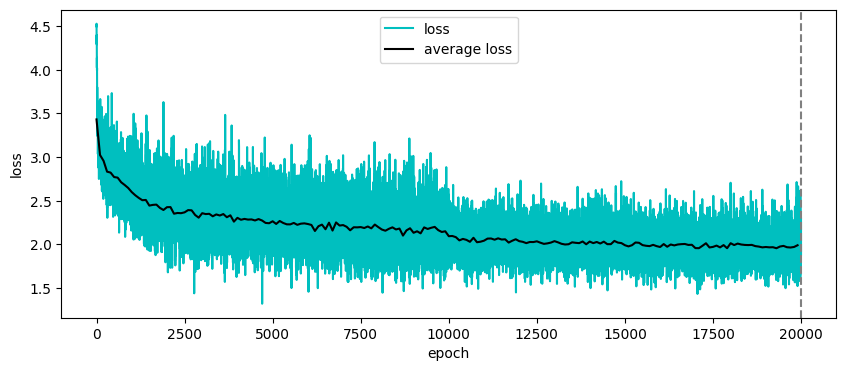

In [7]:
average_each_100 = torch.tensor(loss).view(-1, 100).mean(1)
plt.figure(figsize=(10, 4))
plt.plot(loss, c='c', label='loss')
plt.plot(range(0, len(loss), 100), average_each_100, c='k', label='average loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.axvline(20000, c='gray', linestyle='--');

The loss is still pretty high because our network architecture is very simple and we are not using a too large dataset. Let's generate some text using the network to see if it learned anything.

In [8]:
text = 'Tengo que irme a dormir '
text = [t2i[c] for c in text]
model.eval()
for _ in range(300):
	context = torch.tensor(text[-16:], dtype=torch.long).to(device)
	logits = model(context.unsqueeze(0))
	probs = torch.nn.functional.softmax(logits, dim=-1).squeeze(0)
	completion = torch.multinomial(probs, 1)
	text.append(completion.item())
print(''.join(i2t[i] for i in text))

Tengo que irme a dormir aba y que con --E la cuemanda unorque concontes inse y de sobre que Bobluno en las velarío la seño la vatigo y a sabiono de rontia turcibigedos ya, volé a de gas socque tandado selenor, la para es sallo, Le inta frainadores intenado seobricos al elucho la conese de los óprensa cabas sin la so me div


It still looks a bit like gibberish, but it's already starting to take shape. Some of the properties of Spanish such as the cadence, word length and letters following each other are already present. There are some limiting factors such as the small embedding size, short training, little data, simple architecture and lack of regularization methods, but it's already a good start.